# Sales Project

In [1]:
from google.colab import files
import pathlib, shutil

# make datasets/ and upload the file(s)
pathlib.Path("datasets").mkdir(exist_ok=True)
uploaded = files.upload()  # select sales_data.csv from your computer
for name in uploaded.keys():
    shutil.move(name, f"datasets/{name}")

!ls -lah datasets

Saving sales_data_forecast.csv to sales_data_forecast.csv
Saving sales_data.csv to sales_data.csv
total 33M
drwxr-xr-x 2 root root 4.0K Sep 14 19:01 .
drwxr-xr-x 1 root root 4.0K Sep 14 19:01 ..
-rw-r--r-- 1 root root  32M Sep 14 19:01 sales_data.csv
-rw-r--r-- 1 root root 964K Sep 14 19:01 sales_data_forecast.csv


Let's start by importing necessary libraries and loading the sales dataset.

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

def load_sales_data():
    data_path = Path("datasets/sales_data.csv")
    return pd.read_csv(data_path)

sales = load_sales_data()

## Exploring and understanding the data

Let's start by printing the first five rows.

In [3]:
sales.head()

,store_id,date,is_store_open,is_sale_period,town,n_cust,revenue
0,418,2011-04-01,1,0,Dukem,1053,8828
1,119,2009-08-03,1,0,Yepthton Beach,871,6469
2,791,2010-08-16,1,0,Dukem,901,7186
3,355,2011-09-02,1,0,Dukem,1838,16505
4,624,2011-09-15,1,0,Yepthton Beach,804,7963


We have 7 columns. The first five will be used as inputs, and n_cust as well as revenue are our target variables.

Let's get a quick description of the data.

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885995 entries, 0 to 885994
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   store_id        885995 non-null  int64 
 1   date            885995 non-null  object
 2   is_store_open   885995 non-null  int64 
 3   is_sale_period  885995 non-null  int64 
 4   town            885995 non-null  object
 5   n_cust          885995 non-null  int64 
 6   revenue         885995 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 47.3+ MB


We have 885 995 rows. Five of the columns are integers/numerical attributes (with two categorical variables, 0 and 1), whereas data and town are strings right now.

Let's list the different towns and see how many there are of each.

In [5]:
sales["town"].value_counts()

,count
town,
Dukem,407155
Yepthton Beach,208572
Balntermou,103820
Psey Hill,56628
Rstonemond Hill,32136
Port Shep,24872
Mount Trancesmi,10712
Port Shamlakesmark,10344
Nalliwar,8172


We can see that there are 20 towns. Dukem makes up almost half of the dataset, whereas four of the towns only appear 908 times.

Let's explore the date variable. Let's also add additonal features: year, month, day of the week, and day of the month. Features like day of the week could add information, as people maybe buy more during weekends. The day of the month might also be useful, since people might buy more when they get their salary. Let's also look at the DataFrame again to see the new features.

In [6]:
# Convert date to datetime and create additional features
sales['date'] = pd.to_datetime(sales['date'])
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day_of_week'] = sales['date'].dt.dayofweek
sales['day_of_month'] = sales['date'].dt.day

print("Date range:")
print(f"Start date: {sales['date'].min().strftime('%B %d, %Y')}")
print(f"End date:   {sales['date'].max().strftime('%B %d, %Y')}")
print(f"Duration:   {(sales['date'].max() - sales['date'].min()).days} days")

print("\nRows per year:")
for year in sorted(sales['year'].unique()):
    count = (sales['year'] == year).sum()
    print(f"{year}: {count:,} rows")

print(f"\nTotal rows: {len(sales):,}")
print(f"Average rows per day: {len(sales) / (sales['date'].max() - sales['date'].min()).days:.1f}")

sales.head()

Date range:
Start date: July 07, 2009
End date:   December 31, 2011
Duration:   907 days

Rows per year:
2009: 179,601 rows
2010: 368,285 rows
2011: 338,109 rows

Total rows: 885,995
Average rows per day: 976.8


,store_id,date,is_store_open,is_sale_period,town,n_cust,revenue,year,month,day_of_week,day_of_month
0,418,2011-04-01,1,0,Dukem,1053,8828,2011,4,4,1
1,119,2009-08-03,1,0,Yepthton Beach,871,6469,2009,8,0,3
2,791,2010-08-16,1,0,Dukem,901,7186,2010,8,0,16
3,355,2011-09-02,1,0,Dukem,1838,16505,2011,9,4,2
4,624,2011-09-15,1,0,Yepthton Beach,804,7963,2011,9,3,15


The duration is 907 days, so I'm guessing that the towns that only have 908 entries have one for each day. Towns with many entries have many different stores/store ids'.

Let's understand the store_id column better.

In [7]:
print("Store analysis:")
print(f"Number of unique stores: {sales['store_id'].nunique()}")
print(f"Min store ID: {sales['store_id'].min()}")
print(f"Max store ID: {sales['store_id'].max()}")
print(f"Total rows: {len(sales):,}")
print(f"Average rows per store: {len(sales) / sales['store_id'].nunique():.1f}")

store_counts = sales['store_id'].value_counts()
print(f"\nRows per store:")
print(f"Min rows per store: {store_counts.min()}")
print(f"Max rows per store: {store_counts.max()}")
print(f"Median rows per store: {store_counts.median()}")

print(f"\nStores with most rows:")
print(store_counts.head())
print(f"\nStores with least rows:")
print(store_counts.tail())

Store analysis:
Number of unique stores: 1009
Min store ID: 1
Max store ID: 1009
Total rows: 885,995
Average rows per store: 878.1

Rows per store:
Min rows per store: 724
Max rows per store: 908
Median rows per store: 908.0

Stores with most rows:
store_id
503    908
418    908
119    908
791    908
355    908
Name: count, dtype: int64

Stores with least rows:
store_id
501    724
575    724
644    724
920    724
127    724
Name: count, dtype: int64


We have 1001 stores. Some stores appear 724 times (min, presumably 724 different days) and others 908 times (these are presumably stores that have an entry for each day in the dataset).

Let's now look at the numerical attributes. First, we'll create a function to save images.

In [8]:
IMAGES_PATH = Path() / "images" / "sales_analysis"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

We can now plot a histogram for each numerical attribute (and save it to the images folder).

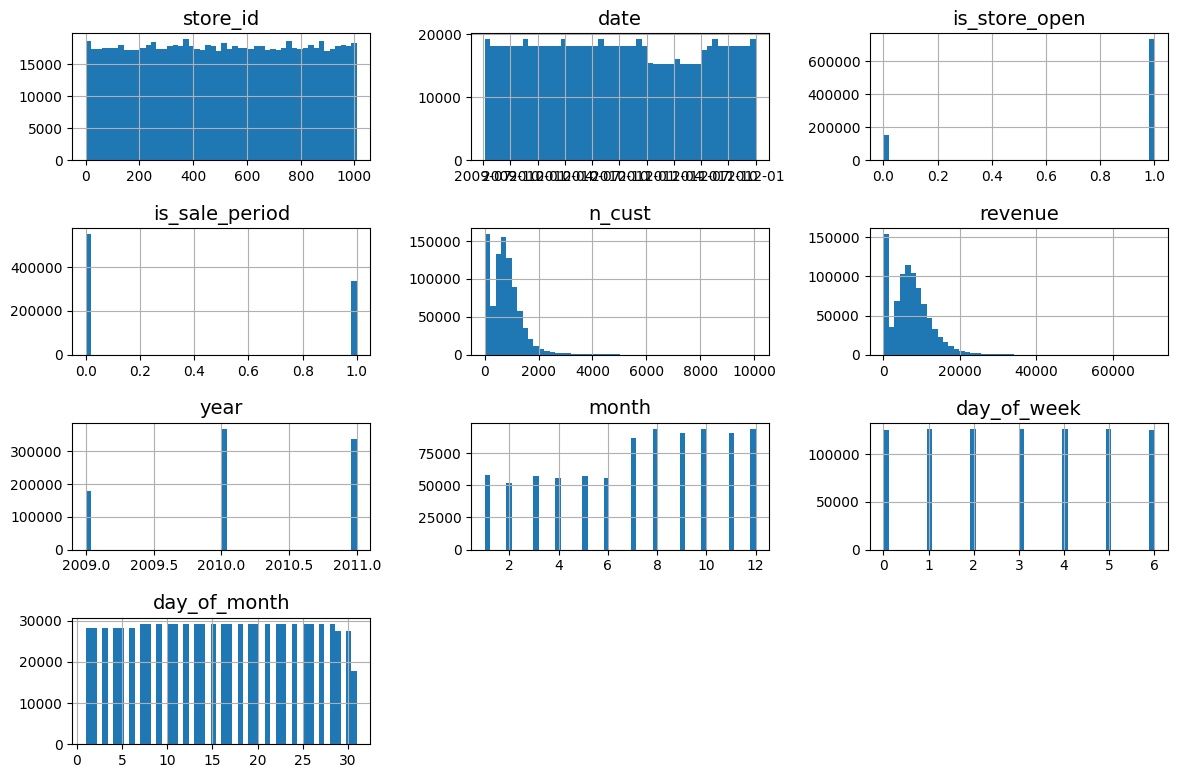

In [9]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

sales.hist(bins=50, figsize=(12, 8))
save_fig("sales_histogram_plots")  # extra code
plt.show()

We can see that the stores are open more often than not, and that it's a sales period in about 350K out of almost 900K rows. The number of customers and the revenue is not normally distributed, rather we can see a right-skewed distribution.

Note: The distibution of the outcome variables suggest we might want to use a tree-based model like XGBoost. We might have to apply log transformations if we use linear models. It also suggests we might want to use MAE. See the sales project report for more.

## Creating a test set

Note: See the report for more information on the reasoning behind creating this test set.

In [10]:
from sklearn.model_selection import train_test_split

# Stratify by town to create a representative test set
train_set, test_set = train_test_split(
    sales,
    test_size=0.2,
    stratify=sales["town"],
    random_state=42
)

print("Town distribution in train set:")
print((train_set["town"].value_counts() / len(train_set) * 100).round(2))
print("\nTown distribution in test set:")
print((test_set["town"].value_counts() / len(test_set) * 100).round(2))

Town distribution in train set:
town
Dukem                 45.95
Yepthton Beach        23.54
Balntermou            11.72
Psey Hill              6.39
Rstonemond Hill        3.63
Port Shep              2.81
Mount Trancesmi        1.21
Port Shamlakesmark     1.17
Nalliwar               0.92
Ny Creek               0.86
Mount Wintor           0.39
Mount Tudo             0.29
Port Raykwi            0.20
Ood                    0.18
Gugam                  0.16
Mount Kenmun           0.16
Motown                 0.10
Mount Peyarchar        0.10
Wadulfield Hill        0.10
Folkbour               0.10
Name: count, dtype: float64

Town distribution in test set:
town
Dukem                 45.95
Yepthton Beach        23.54
Balntermou            11.72
Psey Hill              6.39
Rstonemond Hill        3.63
Port Shep              2.81
Mount Trancesmi        1.21
Port Shamlakesmark     1.17
Nalliwar               0.92
Ny Creek               0.86
Mount Wintor           0.39
Mount Tudo             0.29
Po

Checking that towns are unevenly distributed in sales_data_forecast too.

In [11]:
# Load forecast data and compare town distributions
forecast = pd.read_csv("datasets/sales_data_forecast.csv")

print("Towns distribution in sales_data:")
print(sales['town'].value_counts())
print("\nTown distribution in sales_data_forecast:")
print(forecast['town'].value_counts())

Towns distribution in sales_data:
town
Dukem                 407155
Yepthton Beach        208572
Balntermou            103820
Psey Hill              56628
Rstonemond Hill        32136
Port Shep              24872
Mount Trancesmi        10712
Port Shamlakesmark     10344
Nalliwar                8172
Ny Creek                7620
Mount Wintor            3448
Mount Tudo              2540
Port Raykwi             1816
Ood                     1632
Gugam                   1448
Mount Kenmun            1448
Wadulfield Hill          908
Motown                   908
Folkbour                 908
Mount Peyarchar          908
Name: count, dtype: int64

Town distribution in sales_data_forecast:
town
Dukem                 15742
Yepthton Beach         8058
Balntermou             4046
Psey Hill              2210
Rstonemond Hill        1224
Port Shep               952
Mount Trancesmi         408
Port Shamlakesmark      408
Ny Creek                306
Nalliwar                306
Mount Wintor            136

Let's add the additonal features in sales_data_forecast.csv too.

In [12]:
forecast['date'] = pd.to_datetime(forecast['date'])
forecast['year'] = forecast['date'].dt.year
forecast['month'] = forecast['date'].dt.month
forecast['day_of_week'] = forecast['date'].dt.dayofweek
forecast['day_of_month'] = forecast['date'].dt.day

## Looking at correlations

In [13]:
# Calculate correlations between inputs and outcome variables
corr_matrix = sales.corr(numeric_only=True)

print("Correlations with n_cust (customers):")
print(corr_matrix["n_cust"].sort_values(ascending=False))

print("\nCorrelations with revenue:")
print(corr_matrix["revenue"].sort_values(ascending=False))

Correlations with n_cust (customers):
n_cust            1.000000
revenue           0.903591
is_store_open     0.547118
is_sale_period    0.276769
year              0.019420
store_id          0.013675
month            -0.016976
day_of_month     -0.019281
day_of_week      -0.337566
Name: n_cust, dtype: float64

Correlations with revenue:
revenue           1.000000
n_cust            0.903591
is_store_open     0.600307
is_sale_period    0.395571
year              0.039076
store_id         -0.003909
month            -0.010386
day_of_month     -0.042575
day_of_week      -0.402958
Name: revenue, dtype: float64


We can see that the most informative input variables are likely to be is_store_open, is_sale_period, and day_of_week.

## Preparing the data for training

Let's first make sure there is no missing data that needs to be handled.

In [14]:
print("sales_data:")
print(sales.isnull().sum())
print(f"Sum of missing values: {sales.isnull().sum().sum()}")

# Check missing data in forecast dataset
print("\nsales_data_forecast:")
print(forecast.isnull().sum())
print(f"\Sum of missing values: {forecast.isnull().sum().sum()}")

sales_data:
store_id          0
date              0
is_store_open     0
is_sale_period    0
town              0
n_cust            0
revenue           0
year              0
month             0
day_of_week       0
day_of_month      0
dtype: int64
Sum of missing values: 0

sales_data_forecast:
store_id          0
date              0
is_store_open     0
is_sale_period    0
town              0
year              0
month             0
day_of_week       0
day_of_month      0
dtype: int64
\Sum of missing values: 0


<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:8: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-1158945426.py:8: SyntaxWarning: invalid escape sequence '\S'
  print(f"\Sum of missing values: {forecast.isnull().sum().sum()}")


Let's now separate features from target variables.

In [15]:
X = train_set.drop(['n_cust', 'revenue'], axis=1)
y_cust = train_set['n_cust'].copy()
y_rev = train_set['revenue'].copy()

# Let's drop the date column, it's not useful for training
X = X.drop('date', axis=1)

print("Features shape:", X.shape)
print("Features:", list(X.columns))

Features shape: (708796, 8)
Features: ['store_id', 'is_store_open', 'is_sale_period', 'town', 'year', 'month', 'day_of_week', 'day_of_month']


Let's also one-hot encode town.

In [16]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['town']
X_cat = X[cat_cols]

cat_encoder = OneHotEncoder(sparse_output=False)
X_cat_encoded = cat_encoder.fit_transform(X_cat)

print(f"Number of columns before: {X_cat.shape[1]} column")
print(f"Number of columns after one-hot encoding: {X_cat_encoded.shape[1]} columns")
print("New column names:", cat_encoder.get_feature_names_out())

Number of columns before: 1 column
Number of columns after one-hot encoding: 20 columns
New column names: ['town_Balntermou' 'town_Dukem' 'town_Folkbour' 'town_Gugam' 'town_Motown'
 'town_Mount Kenmun' 'town_Mount Peyarchar' 'town_Mount Trancesmi'
 'town_Mount Tudo' 'town_Mount Wintor' 'town_Nalliwar' 'town_Ny Creek'
 'town_Ood' 'town_Port Raykwi' 'town_Port Shamlakesmark' 'town_Port Shep'
 'town_Psey Hill' 'town_Rstonemond Hill' 'town_Wadulfield Hill'
 'town_Yepthton Beach']


Let's drop the town column and add the one-hot encoded features to X (as inputs).

In [17]:
X_num = X.drop('town', axis=1)

# Convert to DataFrame
X_cat_df = pd.DataFrame(X_cat_encoded,
                       columns=cat_encoder.get_feature_names_out(),
                       index=X.index)

# Combine the numerical and one-hot encoded features
X_final = pd.concat([X_num, X_cat_df], axis=1)

print(f"Original features: {X.shape[1]} columns")
print(f"Final features: {X_final.shape[1]} columns")
print("Final columns:", list(X_final.columns))

Original features: 8 columns
Final features: 27 columns
Final columns: ['store_id', 'is_store_open', 'is_sale_period', 'year', 'month', 'day_of_week', 'day_of_month', 'town_Balntermou', 'town_Dukem', 'town_Folkbour', 'town_Gugam', 'town_Motown', 'town_Mount Kenmun', 'town_Mount Peyarchar', 'town_Mount Trancesmi', 'town_Mount Tudo', 'town_Mount Wintor', 'town_Nalliwar', 'town_Ny Creek', 'town_Ood', 'town_Port Raykwi', 'town_Port Shamlakesmark', 'town_Port Shep', 'town_Psey Hill', 'town_Rstonemond Hill', 'town_Wadulfield Hill', 'town_Yepthton Beach']


Let's inspect this new DataFrame.

In [18]:
print(X_final.head())

        store_id  is_store_open  is_sale_period  year  month  day_of_week  \
54625         95              1               1  2010      7            0   
829477       981              0               1  2009     10            4   
763251       860              1               1  2010     12            0   
403094        54              1               1  2011     12            0   
184232       459              1               0  2011     11            1   

        day_of_month  town_Balntermou  town_Dukem  town_Folkbour  ...  \
54625             12              0.0         0.0            0.0  ...   
829477             2              0.0         1.0            0.0  ...   
763251             6              0.0         0.0            0.0  ...   
403094             5              0.0         0.0            0.0  ...   
184232            15              0.0         0.0            0.0  ...   

        town_Nalliwar  town_Ny Creek  town_Ood  town_Port Raykwi  \
54625             0.0         

## Feature scaling and transformations

We will not replace n_cust and revenue by their logarithm or square root. It would be great as they are right-skewed with a long tail, and most models prefer Gaussian distributions. But because of the zero-inflation problem, it overly complicates things. However, we will standardize numerical features, as most ML algorithms prefer when all features have roughly the same scale.

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)
X_scaled_df = pd.DataFrame(X_scaled,
                          columns=X_final.columns,
                          index=X_final.index)

print("First 5 rows of scaled features:")
print(X_scaled_df.head())

print(f"\nShape: {X_scaled_df.shape}")

First 5 rows of scaled features:
        store_id  is_store_open  is_sale_period      year     month  \
54625  -1.409176       0.454330        1.279801 -0.241229 -0.071513   
829477  1.631734      -2.201041        1.279801 -1.586626  0.815369   
763251  1.216441       0.454330        1.279801 -0.241229  1.406624   
403094 -1.549895       0.454330        1.279801  1.104167  1.406624   
184232 -0.159863       0.454330       -0.781371  1.104167  1.110997   

        day_of_week  day_of_month  town_Balntermou  town_Dukem  town_Folkbour  \
54625     -1.503205     -0.436872        -0.364325   -0.922114      -0.032021   
829477     0.499553     -1.576160        -0.364325    1.084464      -0.032021   
763251    -1.503205     -1.120445        -0.364325   -0.922114      -0.032021   
403094    -1.503205     -1.234374        -0.364325   -0.922114      -0.032021   
184232    -1.002516     -0.095085        -0.364325   -0.922114      -0.032021   

        ...  town_Nalliwar  town_Ny Creek  town_Ood  

Let's also prepare the test data for training using the same steps we used for the training set.

In [20]:
X_test = test_set.drop(['n_cust', 'revenue', 'date'], axis=1)
y_test_cust = test_set['n_cust'].copy()
y_test_rev = test_set['revenue'].copy()

# One-hot encode
X_test_cat = X_test[['town']]
X_test_cat_encoded = cat_encoder.transform(X_test_cat)  # Only transform, don't fit
X_test_cat_df = pd.DataFrame(X_test_cat_encoded,
                            columns=cat_encoder.get_feature_names_out(),
                            index=X_test.index)

# Combine numerical and categorical features
X_test_num = X_test.drop('town', axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat_df], axis=1)

# Scale test set using fitted scaler (transform, not fitting)
X_test_scaled = scaler.transform(X_test_final)

print(f"Training set: {X_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (708796, 27)
Test set: (177199, 27)


## Selecting and training a model

Let's start with Linear Regression (LR). I know it's going to perform poorly. LR expects a Gaussian distribution, and the outcome variables are not Gaussian. But we will make predictions on the training set to see how well it seems to learn from data. We will use Mean Absolute Error (MAE). Since we have outcome variables that are right-skewed, and a lot of zeros, RMSE is a poor metric. It will heavily penalize outliers (which we have a lot of), meaning the RMSE gets dominated by a few large errors. MAE treats all errors equally and is more robust to outliers and gives us the average error of X customers.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np

# Prepare targets (train set)
y_train_cust = train_set['n_cust'].copy()
y_train_rev = train_set['revenue'].copy()

# Train LR for n_cust
lin_reg_cust = LinearRegression()
lin_reg_cust.fit(X_scaled, y_train_cust)

# Train LR for revenue
lin_reg_rev = LinearRegression()
lin_reg_rev.fit(X_scaled, y_train_rev)

# Make predictions on training set
train_pred_cust = lin_reg_cust.predict(X_scaled)
train_pred_rev = lin_reg_rev.predict(X_scaled)

# Calculate training errors (metric = MAE)
print(f"Customers (MAE): {mean_absolute_error(y_train_cust, train_pred_cust):.1f}")
print(f"Revenue (MAE): {mean_absolute_error(y_train_rev, train_pred_rev):.1f}")

# Show some predictions vs actual
print(f"Predicted: {train_pred_cust[:5].round(0)}")
print(f"Actual:    {y_train_cust.iloc[:5].values}")

Customers (MAE): 307.9
Revenue (MAE): 2531.2
Predicted: [551. 396. 826. 986. 633.]
Actual:    [ 588    0  636 1007 1215]


As expected, it performs poorly. Let's try Random Forest (RF) instead. It should be able to handle the non-Gaussian outcome distributions better.

In [23]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest with fewer trees and limited depth for speed
rf_reg_cust = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_reg_cust.fit(X_scaled, y_train_cust)

# Train Random Forest for revenue
rf_reg_rev = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_reg_rev.fit(X_scaled, y_train_rev)

# Make predictions on training set
rf_pred_cust = rf_reg_cust.predict(X_scaled)
rf_pred_rev = rf_reg_rev.predict(X_scaled)

# Calculate training errors
print(f"Customers - MAE: {mean_absolute_error(y_train_cust, rf_pred_cust):.1f}")
print(f"Revenue - MAE: {mean_absolute_error(y_train_rev, rf_pred_rev):.1f}")

Customers - MAE: 96.7
Revenue - MAE: 1143.9


RF performs much better than LR. Let's also try XGBoost.

In [28]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

gpu_params = dict(device="cuda", tree_method="hist")

# Train XGBoost for n_cust
xgb_reg_cust = XGBRegressor(
    n_estimators=100, max_depth=20, random_state=42, n_jobs=-1, **gpu_params
)
xgb_reg_cust.fit(X_scaled, y_train_cust)

# Train XGBoost for revenue
xgb_reg_rev = XGBRegressor(
    n_estimators=100, max_depth=20, random_state=42, n_jobs=-1, **gpu_params
)
xgb_reg_rev.fit(X_scaled, y_train_rev)

# Make predictions on training set
xgb_pred_cust = xgb_reg_cust.predict(X_scaled)
xgb_pred_rev  = xgb_reg_rev.predict(X_scaled)

# Calculate training errors
print(f"Customers - MAE: {mean_absolute_error(y_train_cust, xgb_pred_cust):.1f}")
print(f"Revenue - MAE: {mean_absolute_error(y_train_rev,  xgb_pred_rev):.1f}")


Customers - MAE: 117.7
Revenue - MAE: 929.4


XGBoost also performs well.

Note: I was running this notebook locally first, but it took ages. So I decided to continue on Colab. Due to time-constraints, I'll only continue with XGBoost. It tends to show state-of-the-art performance on tabular data and is likely great for this task since it can handle the outcome distributions and is generally great for regression tasks when we have tabular data. So I feel confident using it. I'll also only do 3-fold cross-validation and a very simple grid search due to time constraints.

Another note: XGBoost doesn't need standardized data (unlike other models), but it doesn't hurt so I'll continue with this set-up.

## Cross-Validation and fine-tuning the model

In [29]:
from sklearn.model_selection import cross_val_score, GridSearchCV

gpu_params = dict(device="cuda", tree_method="hist")
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'learning_rate': [0.1, 0.5]
}

# Hyperparameter tuning for n_cust
xgb_grid_cust = GridSearchCV(
    XGBRegressor(random_state=42, **gpu_params),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=1
)
xgb_grid_cust.fit(X_scaled, y_train_cust)

# Hyperparameter tuning for revenue
xgb_grid_rev = GridSearchCV(
    XGBRegressor(random_state=42, **gpu_params),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=1
)
xgb_grid_rev.fit(X_scaled, y_train_rev)

print("Customers:")
print(f"Best params: {xgb_grid_cust.best_params_}")
print(f"Best CV MAE: {-xgb_grid_cust.best_score_:.1f}")

print("\nRevenue:")
print(f"Best params: {xgb_grid_rev.best_params_}")
print(f"Best CV MAE: {-xgb_grid_rev.best_score_:.1f}")



Customers:
Best params: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 50}
Best CV MAE: 182.5

Revenue:
Best params: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 50}
Best CV MAE: 1503.4


Now we can evaluate the model on the test set.

In [30]:
test_pred_cust = xgb_grid_cust.best_estimator_.predict(X_test_scaled)
test_pred_rev = xgb_grid_rev.best_estimator_.predict(X_test_scaled)

print("Performance on the test set:")
print(f"Customers (MAE): {mean_absolute_error(y_test_cust, test_pred_cust):.1f}")
print(f"Revenue (MAE): {mean_absolute_error(y_test_rev, test_pred_rev):.1f}")

print("\nCV vs Test Comparison:")
print(f"Customers: {-xgb_grid_cust.best_score_:.1f} (CV) vs {mean_absolute_error(y_test_cust, test_pred_cust):.1f} (Test)")
print(f"Revenue: {-xgb_grid_rev.best_score_:.1f} (CV) vs {mean_absolute_error(y_test_rev, test_pred_rev):.1f} (Test)")

Performance on the test set:
Customers (MAE): 181.3
Revenue (MAE): 1484.8

CV vs Test Comparison:
Customers: 182.5 (CV) vs 181.3 (Test)
Revenue: 1503.4 (CV) vs 1484.8 (Test)


## Predicting n_cust and revenue using the forecast CSV file

Let's start by preparing the data, we'll redo all data preprocessing steps to have everything in the same code cell.

In [31]:
forecast = pd.read_csv("datasets/sales_data_forecast.csv")

# Add additional features
forecast['date'] = pd.to_datetime(forecast['date'])
forecast['year'] = forecast['date'].dt.year
forecast['month'] = forecast['date'].dt.month
forecast['day_of_week'] = forecast['date'].dt.dayofweek
forecast['day_of_month'] = forecast['date'].dt.day

# Drop date
X_forecast = forecast.drop(['date'], axis=1)

# One-hot encode towns using the fitted encoder
X_forecast_cat = X_forecast[['town']]
X_forecast_cat_encoded = cat_encoder.transform(X_forecast_cat)
X_forecast_cat_df = pd.DataFrame(X_forecast_cat_encoded,
                                columns=cat_encoder.get_feature_names_out(),
                                index=X_forecast.index)

# Combine numerical and categorical features
X_forecast_num = X_forecast.drop('town', axis=1)
X_forecast_final = pd.concat([X_forecast_num, X_forecast_cat_df], axis=1)

# Scale using scaler fitted on training data
X_forecast_scaled = scaler.transform(X_forecast_final)

print(f"Forecast data shape: {X_forecast_scaled.shape}")
print(f"Features match training: {X_forecast_final.shape[1] == X_final.shape[1]}")

Forecast data shape: (34306, 27)
Features match training: True


Retrain on all data, make predictions, and download the new CSV file.

In [33]:
# Best parameters
best_params_cust = xgb_grid_cust.best_params_
best_params_rev = xgb_grid_rev.best_params_

print(f"Customer model params: {best_params_cust}")
print(f"Revenue model params: {best_params_rev}")

# Combine train and test sets for final training
X_all_scaled = np.vstack([X_scaled, X_test_scaled])
y_all_cust = pd.concat([y_train_cust, y_test_cust])
y_all_rev = pd.concat([y_train_rev, y_test_rev])

# Train final models on all the data
final_cust_model = XGBRegressor(random_state=42, **gpu_params, **best_params_cust)
final_rev_model = XGBRegressor(random_state=42, **gpu_params, **best_params_rev)

final_cust_model.fit(X_all_scaled, y_all_cust)
final_rev_model.fit(X_all_scaled, y_all_rev)

# Make predictions on forecast data
forecast_pred_cust = final_cust_model.predict(X_forecast_scaled)
forecast_pred_rev = final_rev_model.predict(X_forecast_scaled)

# Create output CSV with predictions
output_df = forecast.copy()
output_df['n_cust'] = forecast_pred_cust.round(0).astype(int)
output_df['revenue'] = forecast_pred_rev.round(1)

# Save to CSV
output_path = "sales_data_forecast_with_predictions.csv"
output_df.to_csv(output_path, index=False)

print(f"Shape: {output_df.shape}")
print("\nFirst 5 predictions:")
print(output_df[['store_id', 'date', 'town', 'n_cust', 'revenue']].head())

# Download file
from google.colab import files
files.download(output_path)

Customer model params: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 50}
Revenue model params: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 50}
Shape: (34306, 11)

First 5 predictions:
   store_id       date             town  n_cust       revenue
0         1 2012-02-03   Yepthton Beach     996   8318.900391
1         2 2012-02-03   Yepthton Beach     996   8318.900391
2         3 2012-02-03            Dukem    1279  13737.400391
3         4 2012-02-03   Yepthton Beach     996   8318.900391
4         5 2012-02-03  Mount Trancesmi     560   5156.399902


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## What could be improved

- If I had more time, I would've tried more models. If I had even more time, I would've maybe analyzed the strengths and weaknesses of each model and used an ensamble method.

- More extensive fine-tuning to improve model performance.

- More feature engineering, maybe by combining more features.

